In [3]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import *
from implementations import *
from preprocessing import *

In [4]:
Seed = 42

## Load the Data

In [6]:
p = Preprocessing(load_csv('../dataset/trainset.csv'))
y_train , x_train= p.preprocess()
p = Preprocessing(load_csv('../dataset/testset.csv'))
y_test, x_test = p.preprocess()

In [16]:
print(x_train.shape)
print(x_test.shape)


(225000, 31)
(25000, 31)


## Basic Split


In [17]:
#x_test , x_train ,y_test , y_train = basic_split_data(xt, y, 0.8, Seed)

## Logistic predictions from weights

In [7]:
def predict(weight, x_test):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = calculate_sigmoid(weight, x_test.T)
    
    f = lambda x : 0 if x <0.5 else 1
    
    predictions = np.array([ f(x) for x in pred])
    
    return predictions

## Cross Validation, Calculation of the Accuracy 

In [8]:
def K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, _lambda, gamma, batch_size):
    """
    #K_Cross_Validation training technique
    
    :param xt_training: extended feature matrix 
    :type xt: numpy 2D array
    
    :param y_training: labels
    :type y_training: 1D array
    
    :param K: number of folds
    :type K: int
    
    :param initial_w: initial value of weights
    :type initial_w: numpy 1D array
    
    :param max_iters: the number of maximal iterations
    :type max_iters: int
    
    :param _lambda: regularizer
    :type _lambda: float64
    
    :param gamma: learning rate
    :type gamma: float64
    
    :param batch_size: size of the batch for batch_reg_logistic_regression
    :type batch_size: int
    
    :return: accuracy, validation_weights, accuracy_mean, weights_mean
    :rtype:  1D numpy array,  (K,xt_training.shape[1])numpy array,  float64, 1D numpy array
    
    """

    #Initialization of all needed arrays
    validation_loss = np.zeros(K)
    validation_weights = np.zeros((K,xt_training.shape[1]))
    accuracy = np.zeros(K)
    indices = np.linspace(0, len(y_training)-1 , K+1 ,dtype=int)
    
    for i in range(K):
        #Split de data 
        x_cross_test = xt_training[indices[i] : indices[i+1], :]
        y_cross_test = y_training[indices[i] : indices[i+1]]
        x_cross_train = np.concatenate((xt_training[:indices[i], :], xt_training[indices[i]:, :]),axis=0)
        y_cross_train = np.concatenate((y_training[:indices[i]], y_training[indices[i]:]),axis=0)
        
        #Run Reg_Logistric_Regression on the obtained datasets
        validation_weights[i], validation_loss[i] = reg_batch_logistic_regression(y_cross_train, x_cross_train, _lambda, initial_w, max_iters, gamma, batch_size)
        #Calculate predictions of the model
        predictions = predict(validation_weights[i] , x_cross_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_cross_test) / len(y_cross_test)
        
    return accuracy, validation_weights, np.mean(accuracy), np.mean(validation_weights, axis=0)
        

In [10]:
acc, weights, mean_acc, mean_weights= K_Cross_Validation(x_train, y_train, 20, np.zeros(x_train.shape[1]), 20, 0.1, 0.2, 20)
mean_acc


0.7055675953418084

## Test of the model with the mean of weights obtained with Cross Validation

In [11]:
def Accuracy_On_Test_Set(w, x_test, y_test):     
    #Test the trained model on test set
    predictions = predict(w , x_test)
    accuracy = np.sum(predictions == y_test) / len(y_test)
    
    return accuracy

Accuracy_On_Test_Set(mean_weights, x_test, y_test)

0.70828

## Trying to tune the lambda parameter (regularizer)

In [12]:
def Tune_Lambda(xt_training, y_training, K, lambda_range, initial_w, max_iters, gamma, batch_size):
        
    lambdas = np.linspace(0, lambda_range, 20)
    max_acc = 0
    opt_lambda = 0
    accuracies = []
    for i, lam in enumerate(lambdas):
       
        accuracy = K_Cross_Validation(xt_training, y_training, K, initial_w, max_iters, lam, gamma, batch_size)[2]
        accuracies.append([lam,accuracy])
        if (accuracy > max_acc):
            max_acc = accuracy
            opt_lambda = lam
                
    return opt_lambda , max_acc, np.array(accuracies)

In [16]:
opt_lambda, max_acc, accuracies = Tune_Lambda(xt_training=x_train, y_training=y_train, K= 5, lambda_range=1, initial_w=np.zeros(x_train.shape[1]), max_iters= 30, gamma=0.4, batch_size=20)


In [17]:
accuracies = np.array(accuracies)

0.05263157894736842 0.719305397403893


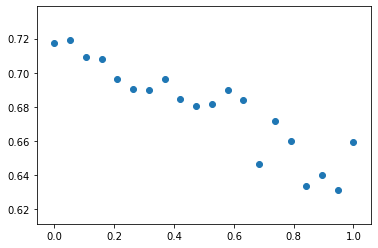

In [18]:
plt.scatter(accuracies[:,0],accuracies[:,1])
print(opt_lambda, max_acc)

## calculate weights with optimal hyperparameters

In [20]:
w, loss_tr = reg_batch_logistic_regression(y_train, x_train, opt_lambda, np.zeros(x_train.shape[1]), 40, 0.4, 30)

In [22]:
np.sum(predict(w,x_test) == y_test) / len(y_test)

0.71792